# LKJ Cholesky Covariance Priors for Multivariate Normal Models

While the [inverse-Wishart distribution](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution) is the conjugate prior for the covariance matrix of a multivariate normal distribution, it is [not very well-suited](https://github.com/pymc-devs/pymc3/issues/538#issuecomment-94153586) to modern Bayesian computational methods.  For this reason, the [LKJ prior](http://www.sciencedirect.com/science/article/pii/S0047259X09000876) is recommended when modeling the covariance matrix of a multivariate normal distribution.

To illustrate modelling covariance with the LKJ distribution, we first generate a two-dimensional normally-distributed sample data set.

In [1]:
%env MKL_THREADING_LAYER=GNU
import arviz as az
import numpy as np
import pymc as pm
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

print(f"Running on PyMC v{pm.__version__}")

env: MKL_THREADING_LAYER=GNU
Running on PyMC v4.0.0b2


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
N = 10000

mu_actual = np.array([1.0, -2.0])
sigmas_actual = np.array([0.7, 1.5])
Rho_actual = np.matrix([[1.0, -0.4], [-0.4, 1.0]])

Sigma_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

x = rng.multivariate_normal(mu_actual, Sigma_actual, size=N)
Sigma_actual

matrix([[ 0.49, -0.42],
        [-0.42,  2.25]])

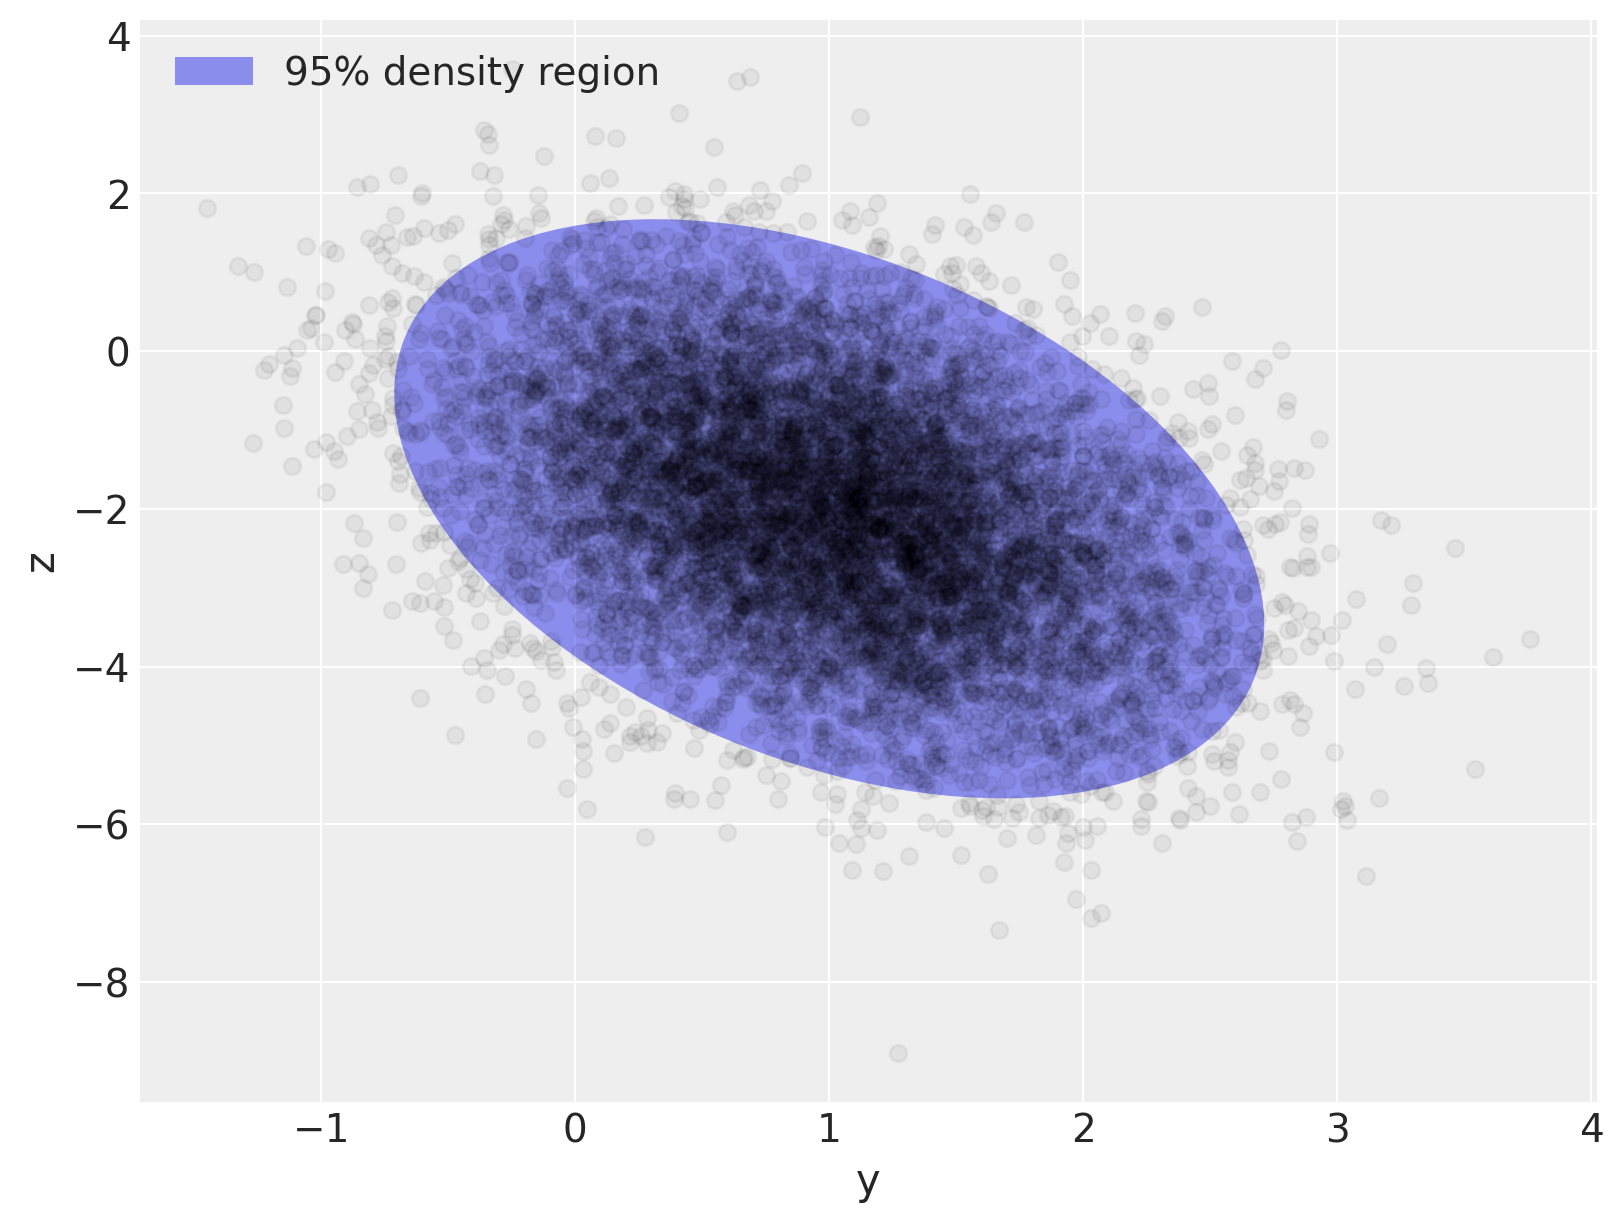

In [4]:
var, U = np.linalg.eig(Sigma_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor("C0")
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)
ax.set_xlabel("y")
ax.set_ylabel("z")

rect = plt.Rectangle((0, 0), 1, 1, fc="C0", alpha=0.5)
ax.legend([rect], ["95% density region"], loc=2);

The sampling distribution for the multivariate normal model is $\mathbf{x} \sim N(\mu, \Sigma)$, where $\Sigma$ is the covariance matrix of the sampling distribution, with $\Sigma_{ij} = \textrm{Cov}(x_i, x_j)$. The density of this distribution is

$$f(\mathbf{x}\ |\ \mu, \Sigma^{-1}) = (2 \pi)^{-\frac{k}{2}} |\Sigma|^{-\frac{1}{2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)\right).$$

The LKJ distribution provides a prior on the correlation matrix, $\mathbf{C} = \textrm{Corr}(x_i, x_j)$, which, combined with priors on the standard deviations of each component, [induces](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A10n416.pdf) a prior on the covariance matrix, $\Sigma$. Since inverting $\Sigma$ is numerically unstable and inefficient, it is computationally advantageous to use the [Cholesky decompositon](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma$, $\Sigma = \mathbf{L} \mathbf{L}^{\top}$, where $\mathbf{L}$ is a lower-triangular matrix. This decompositon allows computation of the term $(\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)$ using back-substitution, which is more numerically stable and efficient than direct matrix inversion.

PyMC supports LKJ priors for the Cholesky decomposition of the covariance matrix via the [LKJCholeskyCov](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.LKJCholeskyCov.html) distribution. This distribution has parameters `n` and `sd_dist`, which are the dimension of the observations, $\mathbf{x}$, and the PyMC distribution of the component standard deviations, respectively. It also has a hyperparamter `eta`, which controls the amount of correlation between components of $\mathbf{x}$. The LKJ distribution has the density $f(\mathbf{C}\ |\ \eta) \propto |\mathbf{C}|^{\eta - 1}$, so $\eta = 1$ leads to a uniform distribution on correlation matrices, while the magnitude of correlations between components decreases as $\eta \to \infty$.

In this example, we model the standard deviations with $\textrm{Exponential}(1.0)$ priors, and the correlation matrix as $\mathbf{C} \sim \textrm{LKJ}(\eta = 2)$.

In [5]:
with pm.Model() as m:
    packed_L = pm.LKJCholeskyCov(
        "packed_L", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False
    )

Since the Cholesky decompositon of $\Sigma$ is lower triangular, `LKJCholeskyCov` only stores the diagonal and sub-diagonal entries, for efficiency:

In [6]:
packed_L.eval()

array([0.13151364, 0.99149846, 2.21931703])

We use [expand_packed_triangular](../api/math.rst) to transform this vector into the lower triangular matrix $\mathbf{L}$, which appears in the Cholesky decomposition $\Sigma = \mathbf{L} \mathbf{L}^{\top}$.

In [7]:
with m:
    L = pm.expand_packed_triangular(2, packed_L)
    Sigma = L.dot(L.T)

L.eval().shape

(2, 2)

Often however, you'll be interested in the posterior distribution of the correlations matrix and of the standard deviations, not in the posterior Cholesky covariance matrix *per se*. Why? Because the correlations and standard deviations are easier to interpret and often have a scientific meaning in the model. As of PyMC v4, the `compute_corr` argument is set to `True` by default, which returns a tuple consisting of the Cholesky decomposition, the correlations matrix, and the standard deviations.

In [8]:
coords = {"axis": ["y", "z"], "axis_bis": ["y", "z"], "obs_id": np.arange(N)}
with pm.Model(coords=coords, rng_seeder=RANDOM_SEED) as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2)
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("axis", "axis_bis"))

To complete our model, we place independent, weakly regularizing priors, $N(0, 1.5),$ on $\mu$:

In [9]:
with model:
    mu = pm.Normal("mu", 0.0, sigma=1.5, dims="axis")
    obs = pm.MvNormal("obs", mu, chol=chol, observed=x, dims=("obs_id", "axis"))

We sample from this model using NUTS and give the trace to [ArviZ](https://arviz-devs.github.io/arviz/) for summarization:

In [10]:
with model:
    trace = pm.sample(
        idata_kwargs={"dims": {"chol_stds": ["axis"], "chol_corr": ["axis", "axis_bis"]}},
    )
az.summary(trace, var_names="~chol", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [chol, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[y],1.00,0.01,0.99,1.01,0.0,0.0,2443.65,1671.88,1.0
mu[z],-2.01,0.01,-2.04,-1.99,0.0,0.0,1727.50,1620.96,1.0
"chol_corr[y, y]",1.00,0.00,1.00,1.00,0.0,0.0,2000.00,2000.00,NaN
"chol_corr[y, z]",-0.40,0.01,-0.42,-0.39,0.0,0.0,3084.27,1657.39,1.0
"chol_corr[z, y]",-0.40,0.01,-0.42,-0.39,0.0,0.0,3084.27,1657.39,1.0
"chol_corr[z, z]",1.00,0.00,1.00,1.00,0.0,0.0,2049.73,2000.00,1.0
chol_stds[y],0.70,0.00,0.69,0.71,0.0,0.0,2840.67,1473.40,1.0
chol_stds[z],1.49,0.01,1.47,1.51,0.0,0.0,2844.58,1582.58,1.0
"cov[y, y]",0.49,0.01,0.48,0.51,0.0,0.0,2840.67,1473.40,1.0
"cov[y, z]",-0.42,0.01,-0.44,-0.40,0.0,0.0,2796.80,1748.75,1.0


Sampling went smoothly: no divergences and good r-hats (except for the diagonal elements of the correlation matrix - however, these are not a concern, because, they should be equal to 1 for each sample for each chain and the variance of a constant value isn't defined. If one of the diagonal elements has `r_hat` defined, it's likely due to tiny numerical errors). 
 
You can also see that the sampler recovered the true means, correlations and standard deviations. As often, that will be clearer in a graph:

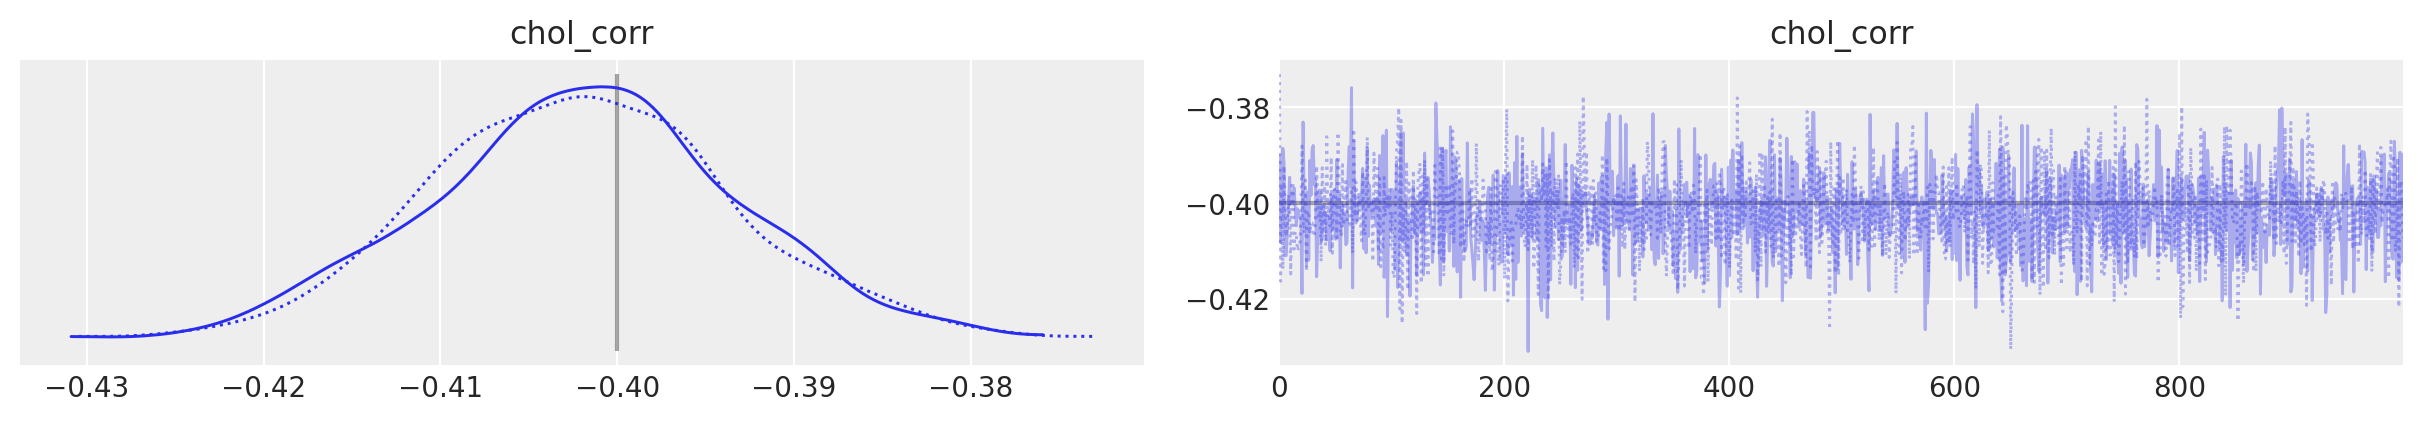

In [11]:
az.plot_trace(
    trace,
    var_names="chol_corr",
    coords={"axis": "y", "axis_bis": "z"},
    lines=[("chol_corr", {}, Rho_actual[0, 1])],
);

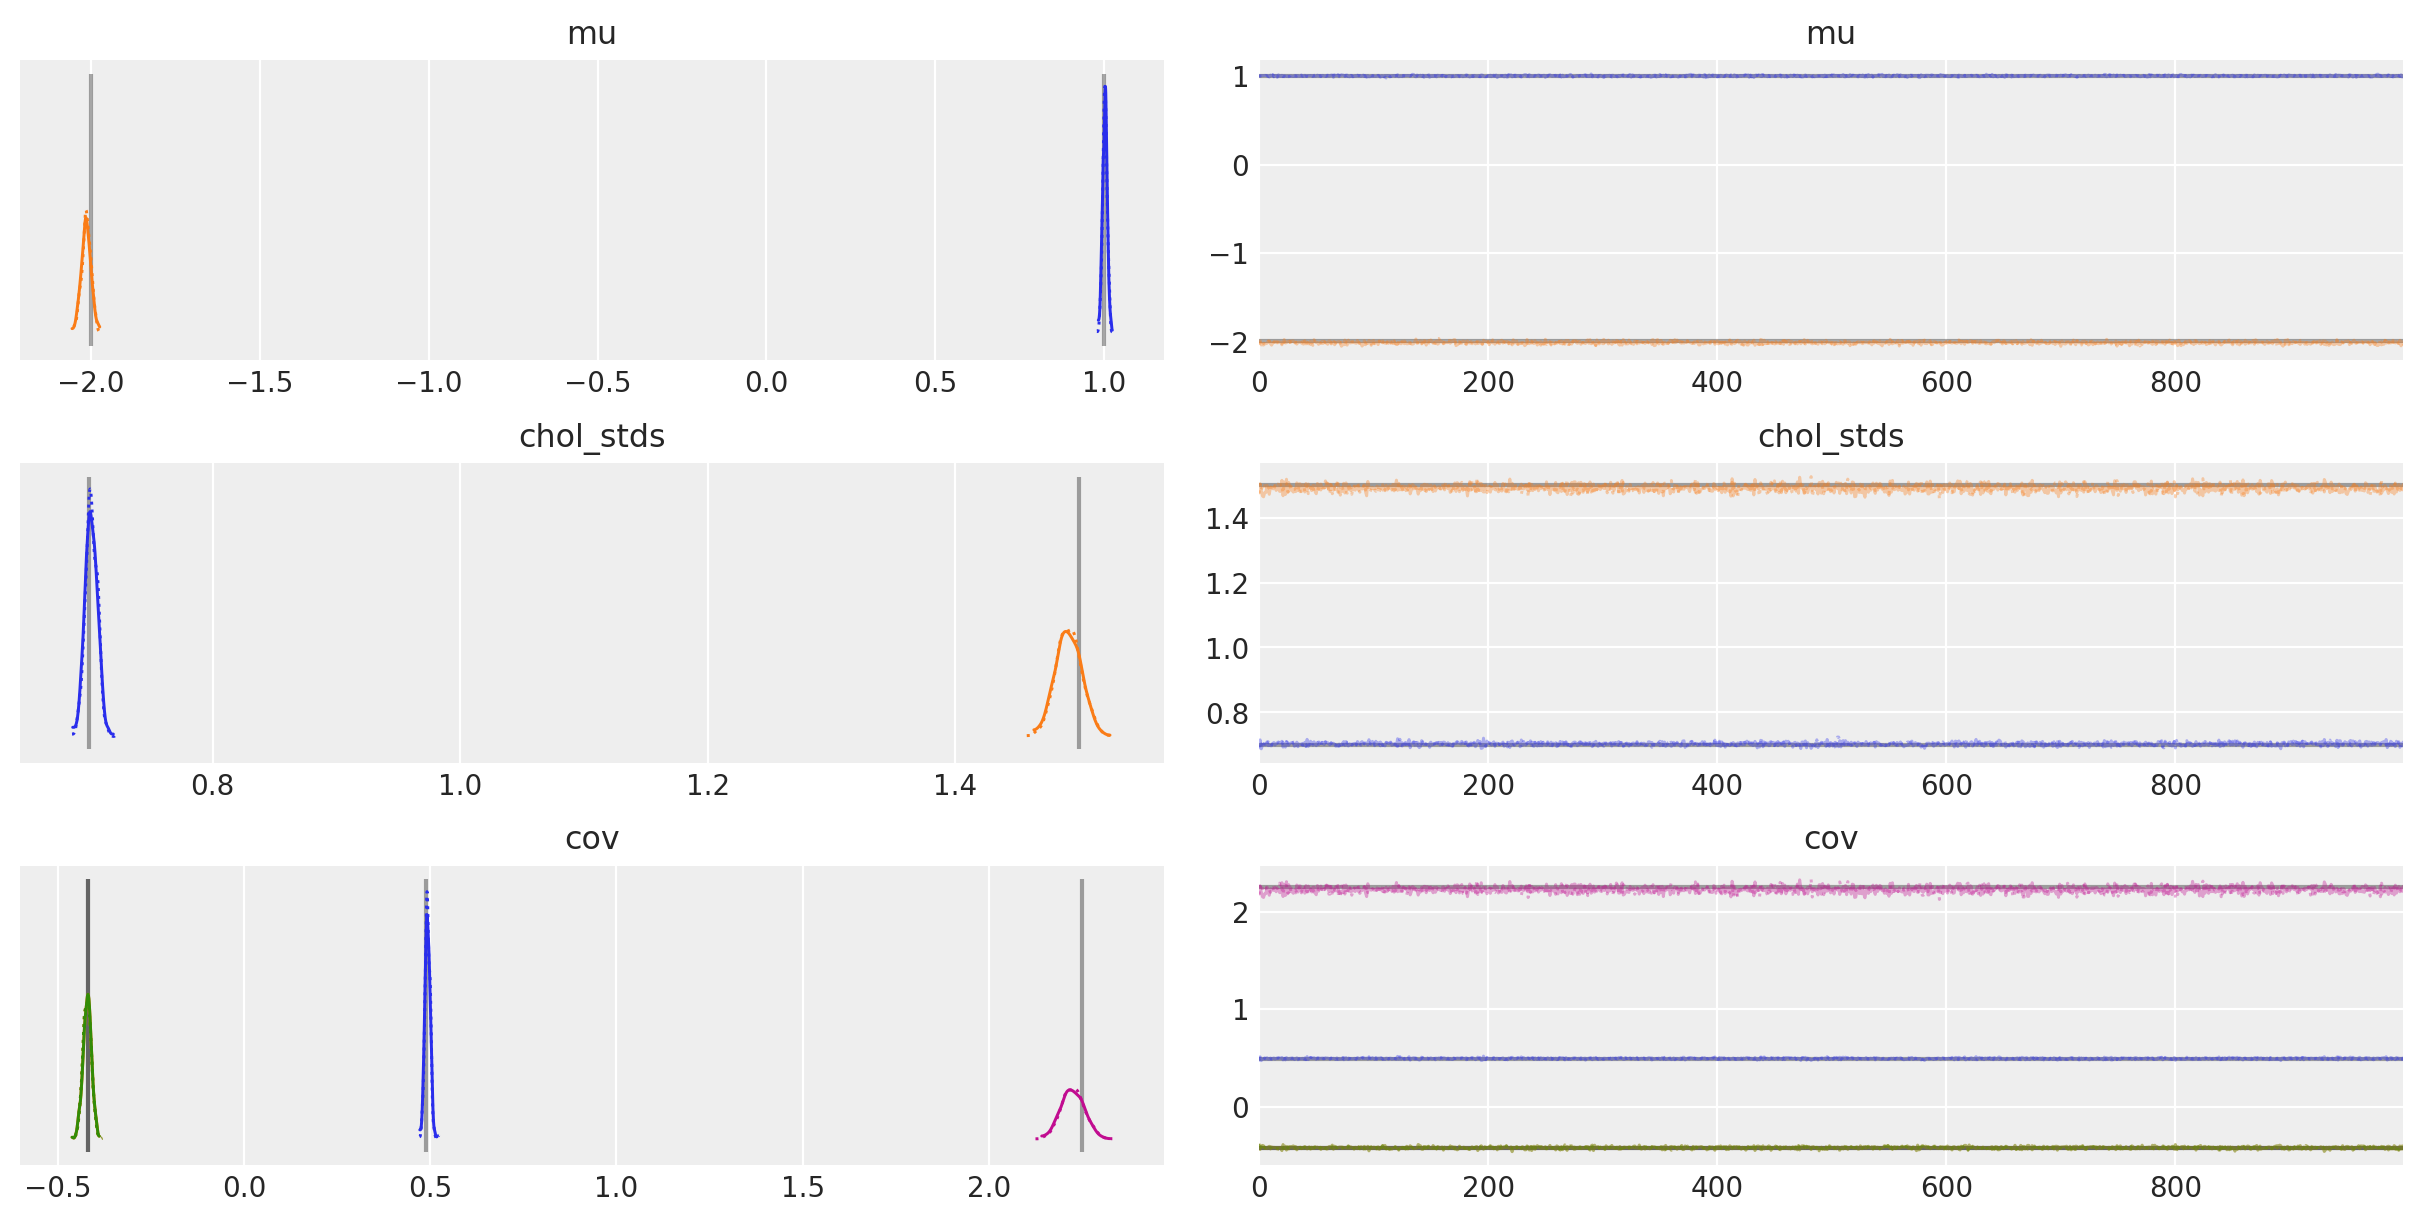

In [12]:
az.plot_trace(
    trace,
    var_names=["~chol", "~chol_corr"],
    compact=True,
    lines=[
        ("mu", {}, mu_actual),
        ("cov", {}, Sigma_actual),
        ("chol_stds", {}, sigmas_actual),
    ],
);

The posterior expected values are very close to the true value of each component! How close exactly? Let's compute the percentage of closeness for $\mu$ and $\Sigma$:

In [13]:
mu_post = trace.posterior["mu"].mean(("chain", "draw")).values
(1 - mu_post / mu_actual).round(2)

array([-0.  , -0.01])

In [14]:
Sigma_post = trace.posterior["cov"].mean(("chain", "draw")).values
(1 - Sigma_post / Sigma_actual).round(2)

array([[-0.01, -0.  ],
       [-0.  ,  0.01]])

So the posterior means are within 3% of the true values of $\mu$ and $\Sigma$.

Now let's replicate the plot we did at the beginning, but let's overlay the posterior distribution on top of the true distribution -- you'll see there is excellent visual agreement between both:

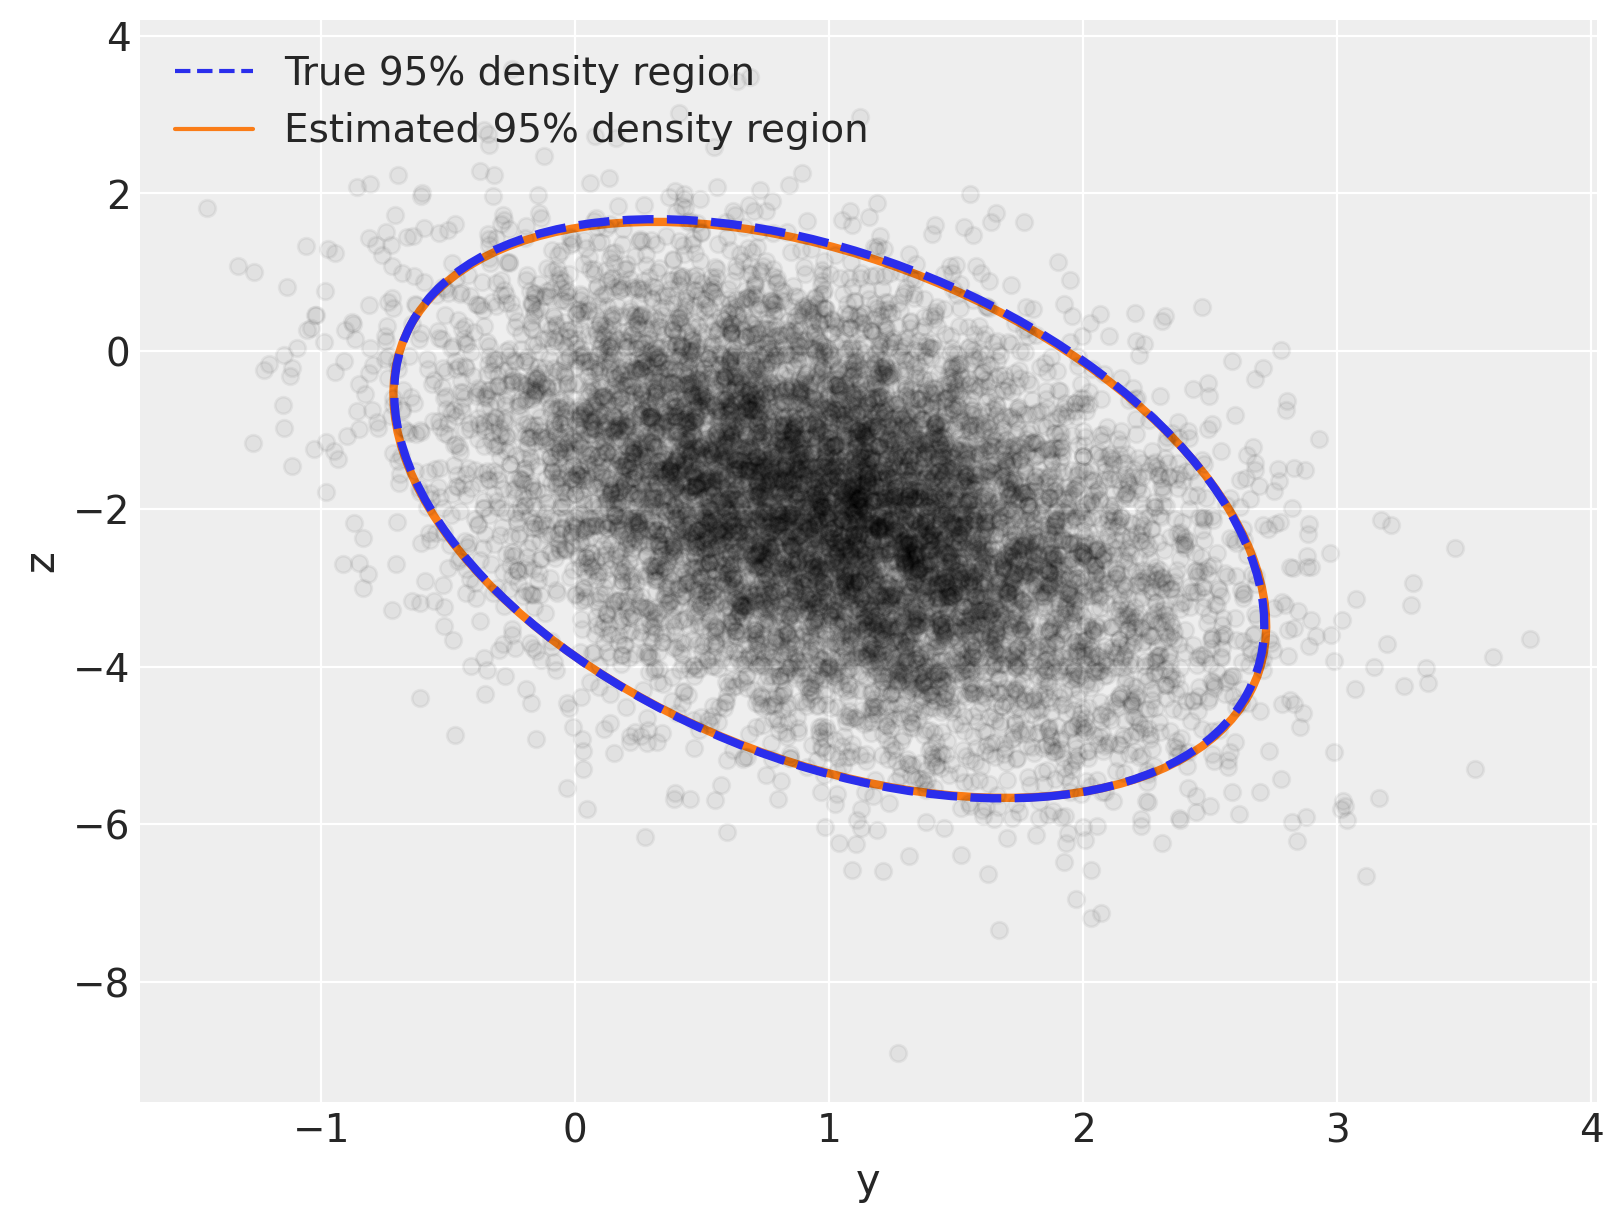

In [15]:
var_post, U_post = np.linalg.eig(Sigma_post)
angle_post = 180.0 / np.pi * np.arccos(np.abs(U_post[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(
    mu_actual,
    2 * np.sqrt(5.991 * var[0]),
    2 * np.sqrt(5.991 * var[1]),
    angle=angle,
    linewidth=3,
    linestyle="dashed",
)
e.set_edgecolor("C0")
e.set_zorder(11)
e.set_fill(False)
ax.add_artist(e)

e_post = Ellipse(
    mu_post,
    2 * np.sqrt(5.991 * var_post[0]),
    2 * np.sqrt(5.991 * var_post[1]),
    angle=angle_post,
    linewidth=3,
)
e_post.set_edgecolor("C1")
e_post.set_zorder(10)
e_post.set_fill(False)
ax.add_artist(e_post)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)
ax.set_xlabel("y")
ax.set_ylabel("z")

line = Line2D([], [], color="C0", linestyle="dashed", label="True 95% density region")
line_post = Line2D([], [], color="C1", label="Estimated 95% density region")
ax.legend(
    handles=[line, line_post],
    loc=2,
);

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Tue Mar 08 2022

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

pytensor: 2.4.0
xarray: 0.18.2

pymc      : 4.0.0b2
matplotlib: 3.2.2
numpy     : 1.21.5
seaborn   : 0.11.2
arviz     : 0.11.4
IPython   : 5.5.0

Watermark: 2.3.0

